Loeb kõik paarid mällu

In [1]:
import pandas as pd
from os import listdir
from os.path import isfile, join
import xml.etree.ElementTree as ET
import ast
from collections import Counter
import time
import json

sample_data = [
    ("Raudam tasak", "biggest"),
    ("Belials jutt3", "smallest")
]

def read_files_from_dir_with_cache(dir):
    answer = Counter()
    for f in listdir(dir):
        if f.endswith(".json"):
            continue
        cache_location = join(dir, f + ".json")
        if isfile(join(dir, f)):
            if isfile(cache_location): 
                cache = open(cache_location, "r")
                answer += Counter(json.load(cache))
                cache.close()
            else:
                from estnltk import Text # 1.6.7 version was used here
                raw_data = Text(formatted_data(join(dir, f))).tag_layer(["words"])
                running_counter = Counter()
                for word in raw_data.words:
                    running_counter[word.text.lower()] += 1
                cache = open(cache_location, "w")
                json.dump(dict(running_counter), cache)
                answer += running_counter
                cache.close()
    return answer

def get_data(root):
    if len(root.getchildren()) == 0:
        if root.text:
            return root.text
        else:
            return ""
    data = ""
    for child in list(root.getchildren()):
        data += f"\n{get_data(child)}"
    return data

def formatted_data(filename):
    data = get_data(ET.parse(filename).getroot())
    return data

texts = [
    (
      name, 
      read_files_from_dir_with_cache(dir)
    ) for name, dir in sample_data
]

SyntaxError: invalid syntax (<ipython-input-1-8dc08a3a837a>, line 46)

In [ ]:
from estnltk.wordnet import wn
import re

def get_synonyms(word):
    return {synset for synset in wn.synsets(word)}

def get_hyperonyms(word):
    return {hyperonym for synset in wn.synsets(word) for hyperonym in synset.hypernyms()}

for name, text in texts:
    print(f"\n\n\n\n{name} failis 100 suurimat sõnade gruppi:\n")
    groups = dict()
    words = dict()
    word_reps = dict()
    
    # Generate a graph
    for word, reps in text.most_common(50000):
        if re.match("^[A-Za-z]*$", word):
            try:
                word_links = get_hyperonyms(word) | get_synonyms(word)
                for link in word_links:
                    if not groups.get(link):
                        groups[link] = set()
                    groups[link].add(word)
                words[word] = word_links
                word_reps[word] = reps
            except Exception:
                pass # unstable functions
    
    def traverse(word, groups, words, graph, used_words):
        for link in words[word]:
            for another in groups[link]:
                if another not in used_words:
                    used_words.add(another)
                    graph.add(another)
                    traverse(another, groups, words, graph, used_words)
    
    graphs = []
    used_words = set()
    for word in words.keys():
        if word not in used_words:
            used_words.add(word)
            graph = {word}
            traverse(word, groups, words, graph, used_words)
            graphs.append(graph)
    
    go = 100
    
    for graph in sorted(graphs, key=lambda x: len(x), reverse=True):
        
        if not go:
            break
        go -= 1
        
        
        name_choise = Counter()
        for elem in graph:
            for link in words[elem]:
                name_choise[link] += word_reps[elem]
        
        choise = name_choise.most_common(1)
        if choise:
            name = choise[0][0].lemmas()[0].name
            print(name, "- grupi elemendid: ", ', '.join(graph), "\n")
        else:
            continue


Tekkis väga suur grupp suurema teksti puhul ning see ei ütle meile väga midagi hetkel. Väiksema teksti puhul siiski andis see asjaliku vastuse

In [ ]:
for name, text in texts:
    print(f"\n\n\n\n{name} failis 100 suurimat sõnade gruppi:\n")
    groups = dict()
    word_reps = dict()
    
    # Generate a graph
    for word, reps in text.most_common(50000):
        if re.match("^[A-Za-z]*$", word):
            try:
                word_links = get_hyperonyms(word) | get_synonyms(word)
                for link in word_links:
                    if not groups.get(link):
                        groups[link] = set()
                    groups[link].add(word)
                word_reps[word] = reps
            except Exception:
                pass # unstable functions
    
    used_words = set()
    sorted_groups = [(k, v) for k, v in sorted(groups.items(), key=lambda item: len(item))]
    disjoint_groups = []
    
    for key, value in sorted_groups:
        new_group = set()
        for word in value:
            if word not in used_words:
                used_words.add(word)
                new_group.add(word)
        disjoint_groups.append((key, new_group))
    
    
    go = 100
    
    for name, elems in sorted(disjoint_groups, key=lambda x: len(x[1]), reverse=True):
        
        if not go:
            break
        go -= 1
        
        if len(elems) > 0:
            res = [f"{x} ({word_reps[x]})" for x in elems]
            print(name.lemmas()[0].name, "- grupi elemendid: ", ', '.join(res), "\n")


### Hinnang

Wordnet andis päris head tulemused. Paar imelikku `hyperonym`'i siiski eksisteeris. Näiteks kana läks inimese gruppi
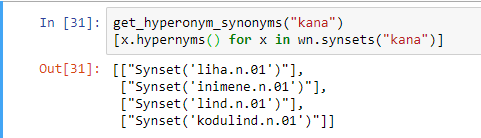

Graafi implementatsioon ei andnud parimaid tulemusi suure andmemahuga.
Aga grupid andsid päris hea ülevaate tekstist ning sisu kokkuvõtte saaks nendest järeldada.

Grupid on kujul: grupi nimi - elemendid: element1 (kordade arv), ...

